#LSTM and ARIMA with RSI (Relative Strength Index) technical indicator


**Students:** Gabriel Sposito and Thomas Frentzel

**LSTM**


In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5a30a3fe247784e3788fa1c5a0a539261e0ca6946cfb06fe1300308e47ff63e9
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator

In [3]:
base = pd.read_csv('Intel 5Y.csv')
base.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$23.32,58650460,$22.25,$23.42,$22.045
1,10/07/2024,$22.38,54928670,$22.40,$22.65,$22.0209
2,10/04/2024,$22.59,49966930,$22.70,$22.91,$22.30
3,10/03/2024,$22.26,49565930,$22.14,$22.73,$21.65
4,10/02/2024,$22.39,59033900,$22.67,$23.0668,$22.35


In [4]:
# Removing nule results
base.dropna()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$23.32,58650460,$22.25,$23.42,$22.045
1,10/07/2024,$22.38,54928670,$22.40,$22.65,$22.0209
2,10/04/2024,$22.59,49966930,$22.70,$22.91,$22.30
3,10/03/2024,$22.26,49565930,$22.14,$22.73,$21.65
4,10/02/2024,$22.39,59033900,$22.67,$23.0668,$22.35
...,...,...,...,...,...,...
1253,10/15/2019,$52.65,18970760,$51.93,$53.07,$51.83
1254,10/14/2019,$51.64,16425530,$51.90,$51.95,$51.44
1255,10/11/2019,$52.09,24167110,$52.00,$52.79,$51.82
1256,10/10/2019,$51.11,14611660,$50.41,$51.775,$50.40


In [5]:
# Removing $
base['Close/Last'] = base['Close/Last'].str.replace('$', '')
base['Open'] = base['Open'].str.replace('$', '')
base['High'] = base['High'].str.replace('$', '')
base['Low'] = base['Low'].str.replace('$', '')

# Converting str to float
base['Close/Last'] = base['Close/Last'].astype(float)
base['Open'] = base['Open'].astype(float)
base['High'] = base['High'].astype(float)
base['Low'] = base['Low'].astype(float)

In [6]:
cci = CCIIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'], window=20, constant=0.015)
base['CCI'] = cci.cci()

sma_tp = base['High'] + base['Low'] + base['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base['Close/Last'], window=14)
base['RSI'] = rsi.rsi()

macd = MACD(close=base['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base['MACD'] = macd.macd()
base['MACD_Signal'] = macd.macd_signal()
base['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base['High'], low=base['Low'], close=base['Close/Last'])
base['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base['Close/Last'], window=20, window_dev=2)
base['Bollinger_High'] = bollinger.bollinger_hband()
base['Bollinger_Low'] = bollinger.bollinger_lband()
base['Bollinger_Middle'] = bollinger.bollinger_mavg()
base['Bollinger_Width'] = bollinger.bollinger_wband()

base.dropna()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,21.41,57028870,21.072,21.440,21.0700,109.236141,54.112274,-0.365474,-0.606827,0.241353,19.455067,21.792245,18.378755,20.08550,16.994799
34,08/20/2024,20.99,84161270,21.210,21.230,20.8200,82.525909,51.262625,-0.290474,-0.543556,0.253082,19.561664,21.823466,18.369534,20.09650,17.186732
35,08/19/2024,21.52,65956300,20.885,21.860,20.8350,124.006703,54.517618,-0.186125,-0.472070,0.285945,19.663997,21.834038,18.363962,20.09900,17.264916
36,08/16/2024,20.87,48582660,20.530,20.895,20.4101,57.383431,50.098507,-0.154100,-0.408476,0.254376,19.762238,21.828382,18.365618,20.09700,17.230254
37,08/15/2024,20.69,84814880,20.320,21.060,20.2300,46.431701,48.916029,-0.141612,-0.355103,0.213491,19.856548,21.886088,18.410912,20.14850,17.247812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,10/15/2019,52.65,18970760,51.930,53.070,51.8300,-68.893127,32.656899,-1.587661,-1.307755,-0.279905,53.235976,60.363386,49.940114,55.15175,18.899260
1254,10/14/2019,51.64,16425530,51.900,51.950,51.4400,-81.645295,28.543524,-1.611303,-1.368465,-0.242838,53.070000,60.025053,49.607447,54.81625,19.004594
1255,10/11/2019,52.09,24167110,52.000,52.790,51.8200,-59.811562,32.615978,-1.575567,-1.409885,-0.165681,51.029100,59.591590,49.422910,54.50725,18.655647
1256,10/10/2019,51.11,14611660,50.410,51.775,50.4000,-83.377075,28.770423,-1.607790,-1.449466,-0.158323,52.790000,59.176915,49.143585,54.16025,18.525264


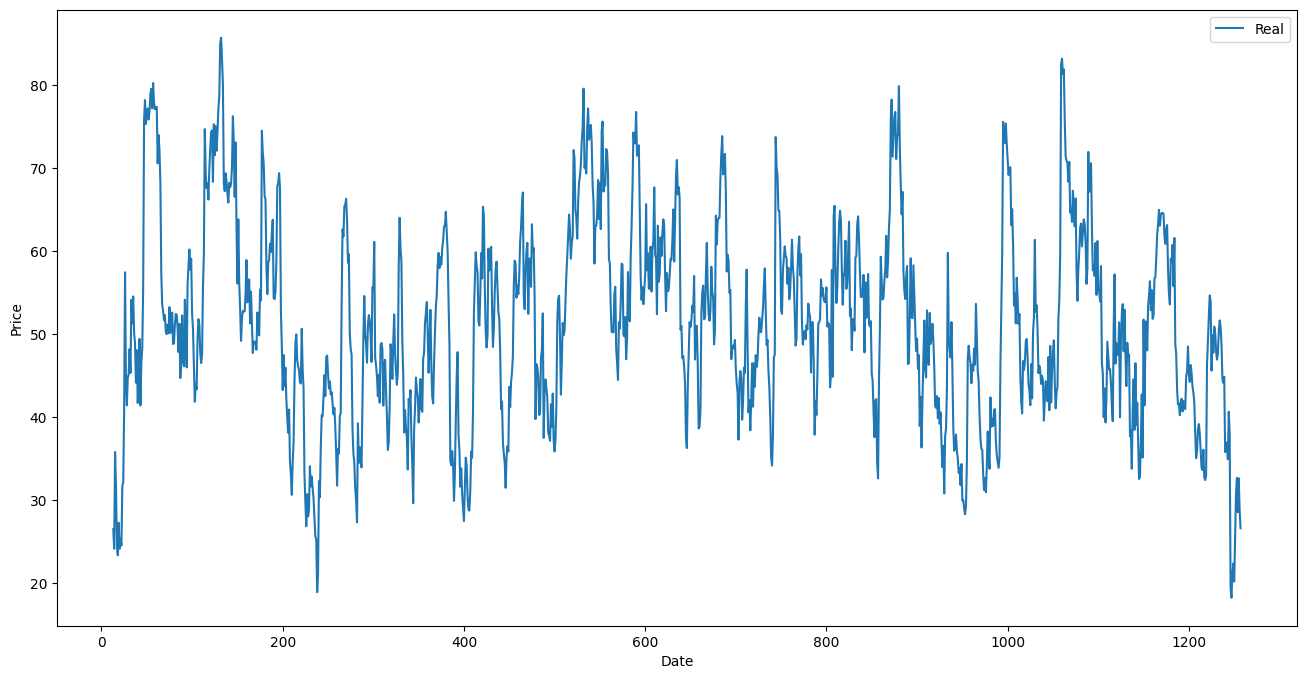

In [7]:
plt.figure(figsize=(16,8))
plt.plot(base['RSI'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

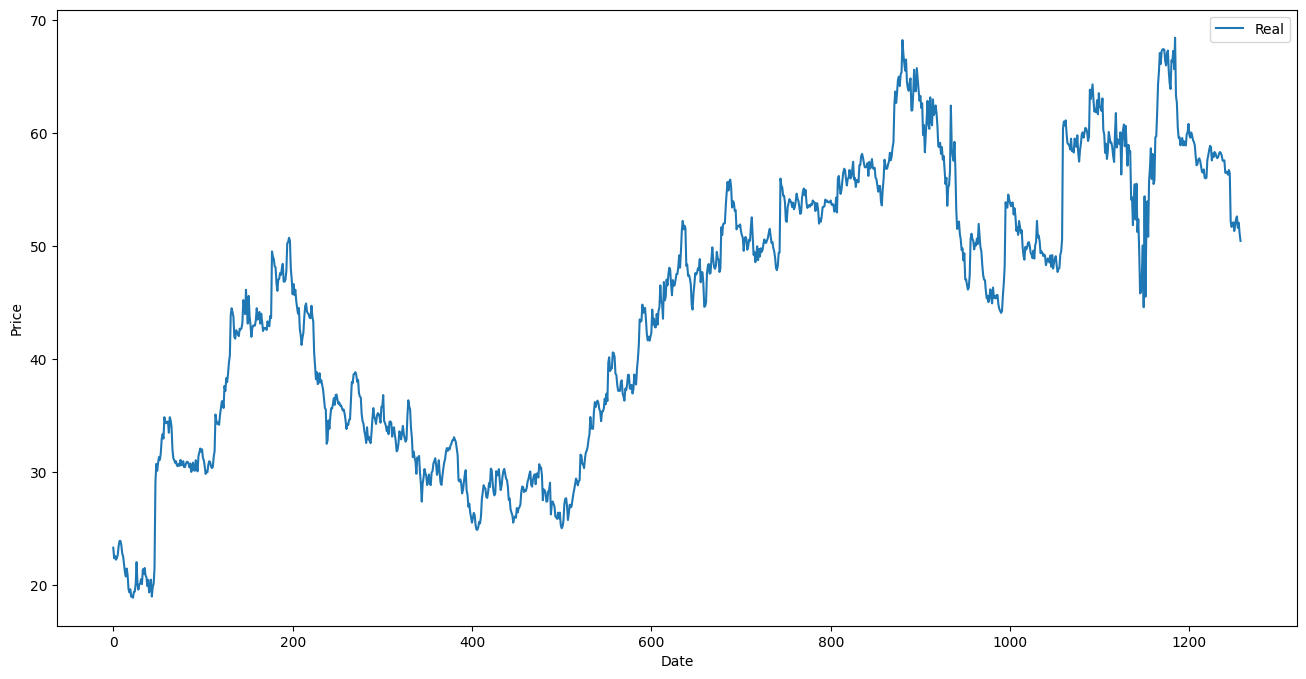

In [8]:
plt.figure(figsize=(16,8))
plt.plot(base['Close/Last'], label='Real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [9]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base = base.replace([np.inf, -np.inf], np.nan)
base = base.dropna()

In [10]:
# Normalizing the data of real values
scaler_real_value = MinMaxScaler(feature_range=(0, 1))
scaled_data_real_value = scaler_real_value.fit_transform(np.array(base['Close/Last']).reshape(-1, 1))

In [11]:
window_size_real_value = 10
forecasters_real_value = []
real_value_of_prices = []
for i in range(window_size_real_value, len(base)):
    forecasters_real_value.append(scaled_data_real_value[i - window_size_real_value:i, 0])
    real_value_of_prices.append(scaled_data_real_value[i, 0])

forecasters_real_value, real_value_of_prices = np.array(forecasters_real_value), np.array(real_value_of_prices)
forecasters_real_value = np.reshape(forecasters_real_value, (forecasters_real_value.shape[0], forecasters_real_value.shape[1], 1))

In [12]:
#dividindo a coluna close/last em 70% treino e 30% teste com trai_test_split
Xtrain_real_lstm, Xtest_real_lstm, ytrain_real_lstm, ytest_real_lstm = train_test_split(forecasters_real_value, real_value_of_prices,
                                                                                        test_size = 0.3, shuffle = False)

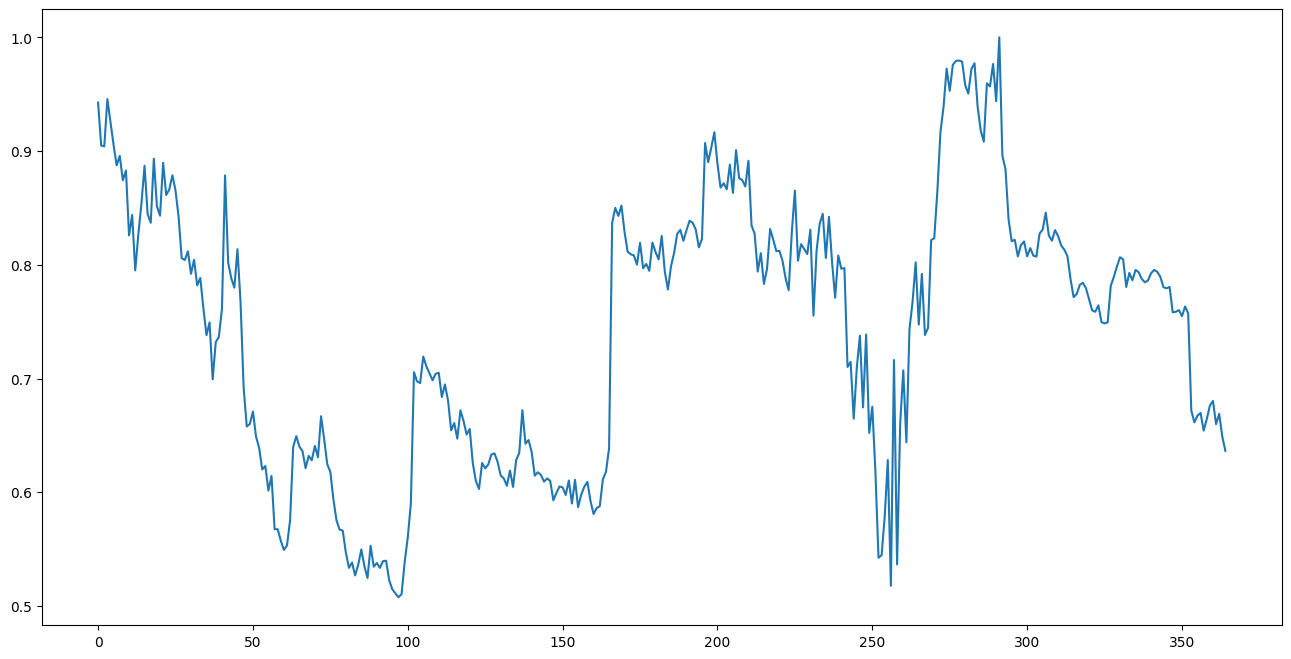

In [13]:
#plotando grafico dos valores de teste
plt.figure(figsize=(16,8))
plt.plot(ytest_real_lstm)
plt.show()

In [14]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(base['RSI']).reshape(-1, 1))

In [15]:
window_size = 10
forecasters = []
real_value = []
for i in range(window_size, len(base)):
    forecasters.append(scaled_data[i - window_size:i, 0])
    real_value.append(scaled_data[i, 0])

forecasters, real_value = np.array(forecasters), np.array(real_value)
forecasters = np.reshape(forecasters, (forecasters.shape[0], forecasters.shape[1], 1))

In [16]:
# Separating data between training and testing
X_train, X_test, y_train, y_test = train_test_split(forecasters, real_value, test_size=0.3, shuffle=False)

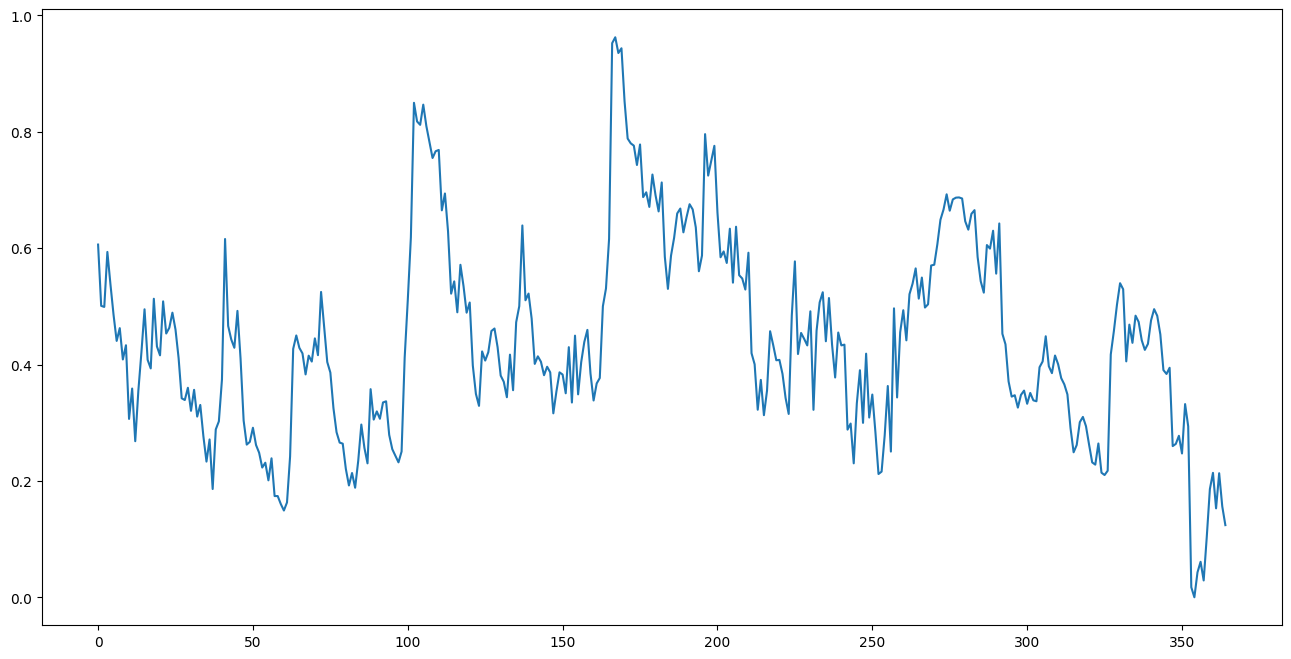

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(y_test)
plt.show()

In [18]:
# LSTM model

lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(forecasters.shape[1], 1)))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50, return_sequences=True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(units=50))
lstm.add(Dropout(0.3))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.1325 - mean_absolute_error: 0.3029 - val_loss: 0.0180 - val_mean_absolute_error: 0.1014
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0233 - mean_absolute_error: 0.1203 - val_loss: 0.0198 - val_mean_absolute_error: 0.1100
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0250 - mean_absolute_error: 0.1267 - val_loss: 0.0186 - val_mean_absolute_error: 0.1054
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0231 - mean_absolute_error: 0.1189 - val_loss: 0.0175 - val_mean_absolute_error: 0.1011
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0220 - mean_absolute_error: 0.1194 - val_loss: 0.0166 - val_mean_absolute_error: 0.0968
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0240 - mean_absolute_error: 0.1255 - val_loss: 0.0169 - val_mean_absolute_error: 0.0994
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0193 - mean_absolute_error: 0.1106 - v

In [20]:
test_predictions = lstm.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [21]:
# Transforming test values ​​back to original values
y_orig_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#escalonando valores de teste
ytest_real_lstm = scaler_real_value.inverse_transform(ytest_real_lstm.reshape(-1, 1))

In [22]:
test_predictions = test_predictions.ravel()
y_orig_test = y_orig_test.ravel()
ytest_real_lstm = ytest_real_lstm.ravel()

In [23]:
test_size_L = len(y_test)

rsi_test = base['RSI'].tail(test_size_L)
close_test = base['Close/Last'].tail(test_size_L)

In [24]:
# Inverse RSI formula
def inverse_rsi(predictions, close_prices, rsi_values, period=14):
    inverted_values = []

    for rsi, pred, close in zip(rsi_values, predictions, close_prices):
        # Calculates real RS from RSI
        rs_real = (100 - rsi) / rsi

        # Reverse predicted RSI to get RS (relative strength) estimate
        rs_pred = (100 - pred) / pred

        # Calculates the price change based on the difference between actual and forecast RS considering that RS = average gains / average losses
        gain = (rs_pred - rs_real) * close / (1 + rs_real)
        inverted_price = close + gain

        inverted_values.append(inverted_price)

    return np.array(inverted_values)

In [25]:
# Inverting the values ​​test_predictions and y_orig_teste by the inverse RSI formula
test_predictions_inverted = inverse_rsi(test_predictions, close_test, rsi_test)
y_orig_test_inverted = inverse_rsi(y_orig_test, close_test, rsi_test)

min_length = min(len(ytest_real_lstm), len(test_predictions_inverted))
ytest_real_lstm = ytest_real_lstm[:min_length]
test_predictions_inverted = test_predictions_inverted[:min_length]

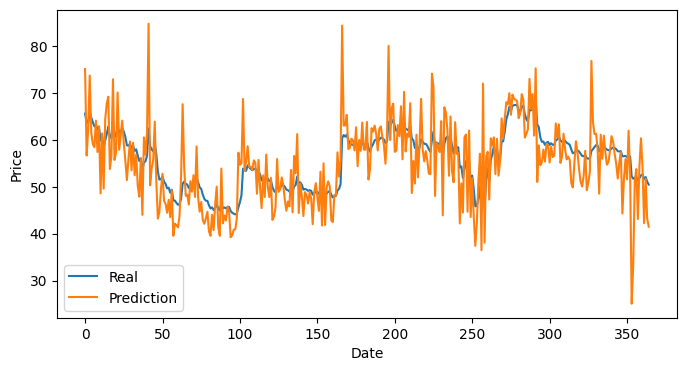

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(ytest_real_lstm)), ytest_real_lstm, label='Real')
plt.plot(range(len(test_predictions_inverted)), test_predictions_inverted, label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [27]:
# R2 Score
r2 = r2_score(y_orig_test_inverted, test_predictions_inverted)
print(f'R2 Score: {r2}')

# RMSE
rmse = np.sqrt(np.mean((y_orig_test_inverted - test_predictions_inverted) ** 2))
print(f'RMSE: {rmse}')

R2 Score: 0.0912801293256651
RMSE: 5.5712955907554145


**ARIMA**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ta.trend import CCIIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import PSARIndicator
from math import sqrt

In [29]:
base_A = pd.read_csv('Intel 5Y.csv')
base_A.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/08/2024,$23.32,58650460,$22.25,$23.42,$22.045
1,10/07/2024,$22.38,54928670,$22.40,$22.65,$22.0209
2,10/04/2024,$22.59,49966930,$22.70,$22.91,$22.30
3,10/03/2024,$22.26,49565930,$22.14,$22.73,$21.65
4,10/02/2024,$22.39,59033900,$22.67,$23.0668,$22.35


In [30]:
base_A.dtypes

,0
Date,object
Close/Last,object
Volume,int64
Open,object
High,object
Low,object


In [31]:
# Removing $
base_A['Close/Last'] = base_A['Close/Last'].str.replace('$', '')
base_A['Open'] = base_A['Open'].str.replace('$', '')
base_A['High'] = base_A['High'].str.replace('$', '')
base_A['Low'] = base_A['Low'].str.replace('$', '')

# Converting str to float
base_A['Close/Last'] = base_A['Close/Last'].astype(float)
base_A['Open'] = base_A['Open'].astype(float)
base_A['High'] = base_A['High'].astype(float)
base_A['Low'] = base_A['Low'].astype(float)

In [ ]:
cci = CCIIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'], window=20, constant=0.015)
base_A['CCI'] = cci.cci()

sma_tp = base_A['High'] + base_A['Low'] + base_A['Close/Last'] / 3
sma_tp = sma_tp.rolling(window=20).mean()
mean_deviation = np.mean(np.abs(base_A['Close/Last'] - sma_tp))

rsi = RSIIndicator(close=base_A['Close/Last'], window=14)
base_A['RSI'] = rsi.rsi()

macd = MACD(close=base_A['Close/Last'], window_slow=26, window_fast=12, window_sign=9)
base_A['MACD'] = macd.macd()
base_A['MACD_Signal'] = macd.macd_signal()
base_A['MACD_Diff'] = macd.macd_diff()

psar = PSARIndicator(high=base_A['High'], low=base_A['Low'], close=base_A['Close/Last'])
base_A['Parabolic_SAR'] = psar.psar()

bollinger = BollingerBands(close=base_A['Close/Last'], window=20, window_dev=2)
base_A['Bollinger_High'] = bollinger.bollinger_hband()
base_A['Bollinger_Low'] = bollinger.bollinger_lband()
base_A['Bollinger_Middle'] = bollinger.bollinger_mavg()
base_A['Bollinger_Width'] = bollinger.bollinger_wband()

base_A.dropna()

In [ ]:
# Converting indicator values ​​to numeric values ​​and removing NaN values
base_A = base_A.replace([np.inf, -np.inf], np.nan)
base_A = base_A.dropna()

In [ ]:
base_A.head()

,Date,Close/Last,Volume,Open,High,Low,CCI,RSI,MACD,MACD_Signal,MACD_Diff,Parabolic_SAR,Bollinger_High,Bollinger_Low,Bollinger_Middle,Bollinger_Width
33,08/21/2024,128.50,257883600,127.315,129.35,126.66,109.563550,59.206678,1.479949,-0.959813,2.439762,115.264796,133.280229,100.584771,116.9325,27.960967
34,08/20/2024,127.25,300087400,128.400,129.88,125.89,93.439821,57.552758,1.795072,-0.408836,2.203908,117.184220,134.480982,100.772018,117.6265,28.657628
35,08/19/2024,130.00,318333600,124.280,130.00,123.42,85.454132,60.187685,2.240879,0.121107,2.119773,118.873314,136.004529,100.689471,118.3470,29.840264
36,08/16/2024,124.58,302589900,121.940,125.00,121.18,43.621331,53.180795,2.132257,0.523337,1.608920,120.359716,136.582416,100.891584,118.7370,30.058729
37,08/15/2024,122.86,318086700,118.760,123.24,117.47,20.947193,51.145899,1.885647,0.795799,1.089848,131.260000,136.860746,100.989254,118.9250,30.163121


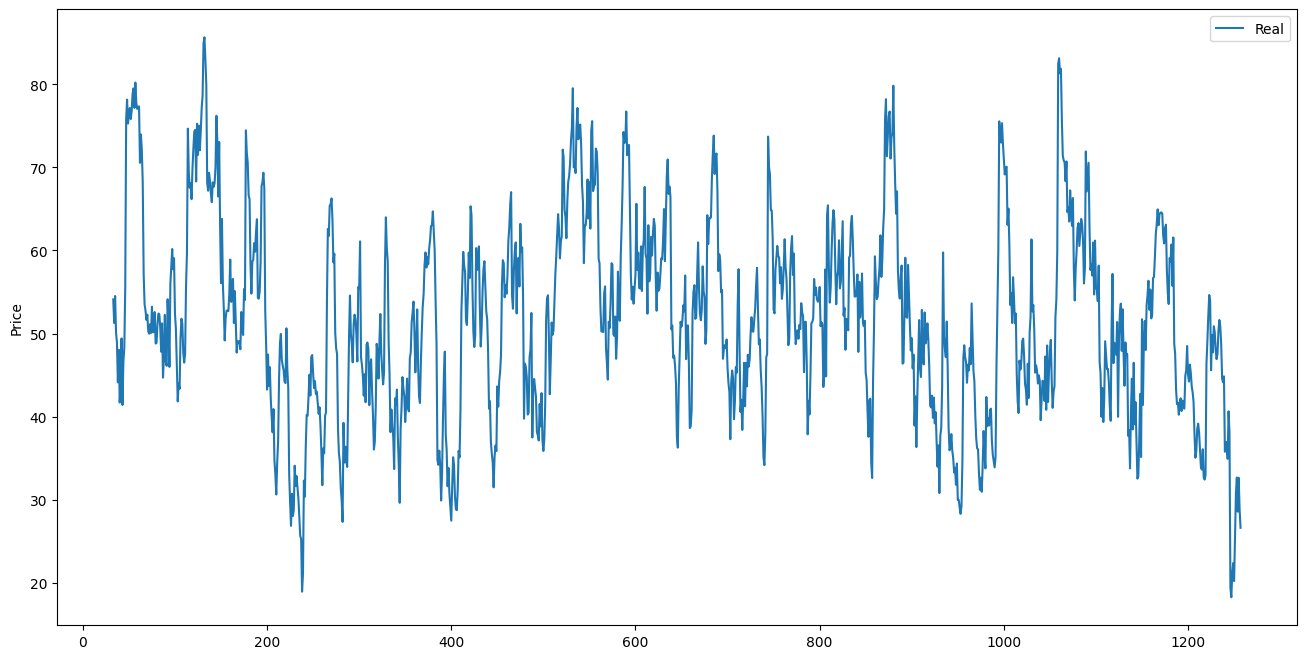

In [ ]:
#Plotting RSI
plt.figure(figsize=(16,8))
plt.plot(base_A['RSI'], label='Real')
plt.ylabel('Price')
plt.legend()

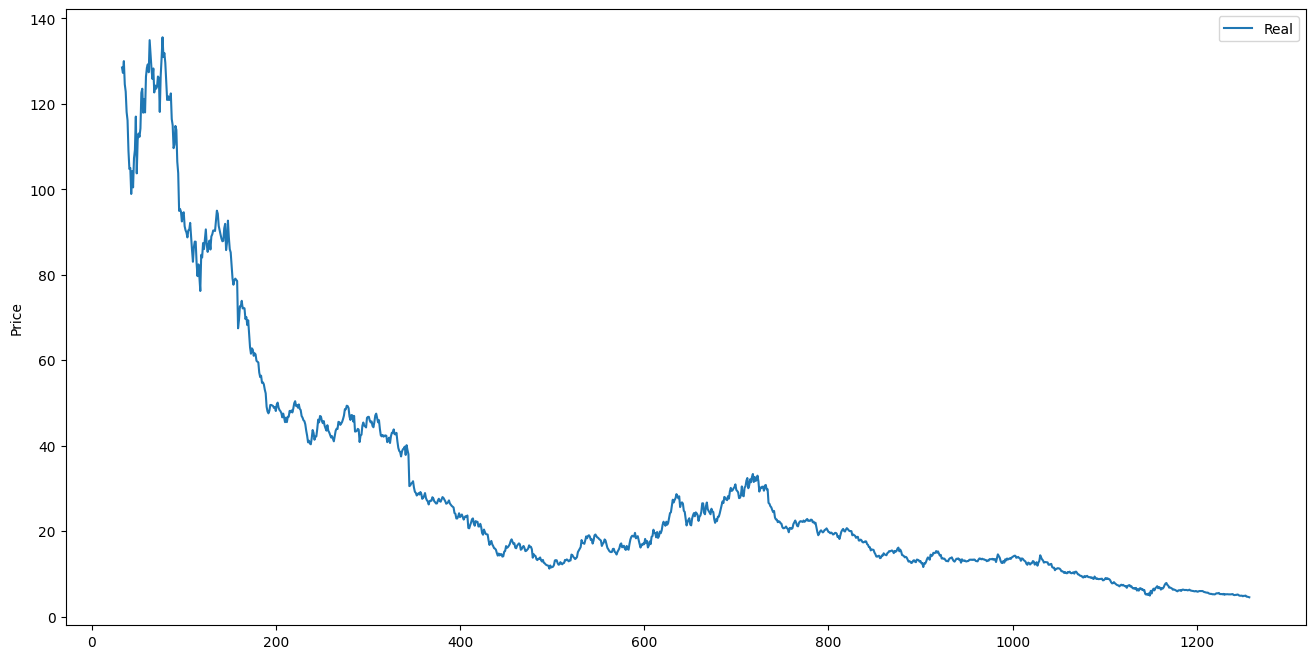

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(base_A['Close/Last'], label='Real')
plt.ylabel('Price')
plt.legend()

In [ ]:
X_R = base_A['Close/Last'].values
size_R = int(len(X_R) * 0.70)
train_R, test_R = X_R[0:size_R], X_R[size_R:len(X_R)]
history_R = [x_r for x_r in train_R]
forecasts_R = list()

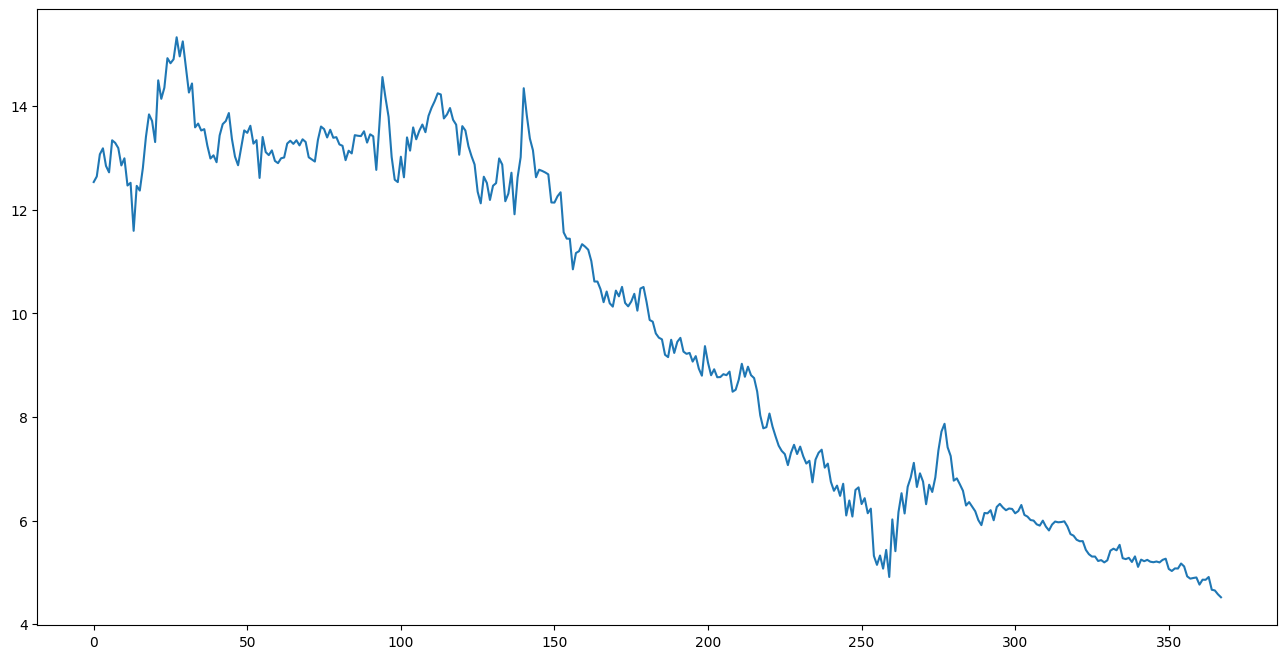

In [ ]:
#Test Grafic
plt.figure(figsize=(16, 8))
plt.plot(test_R)
plt.show()

In [ ]:
# Addfuller for RSI
result = adfuller(base_A['RSI'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.092389374129575
p-value: 1.0290431249968746e-07


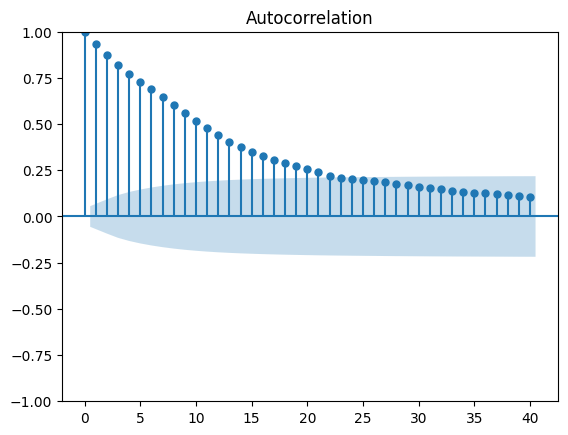

In [ ]:
plot_acf(base_A['RSI'], lags=40)
plt.show()

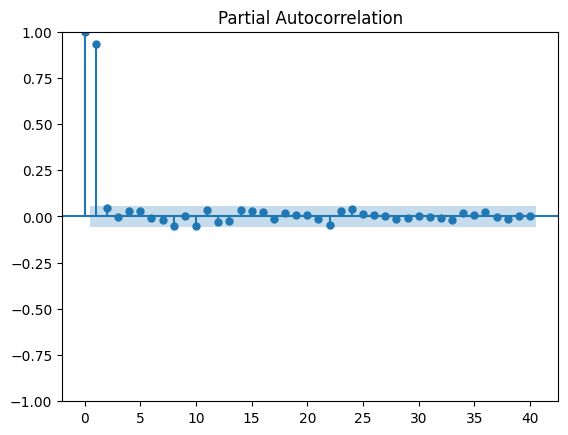

In [ ]:
plot_pacf(base_A['RSI'], lags=40)
plt.show()

In [ ]:
X = base_A['RSI'].values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
forecasts = list()

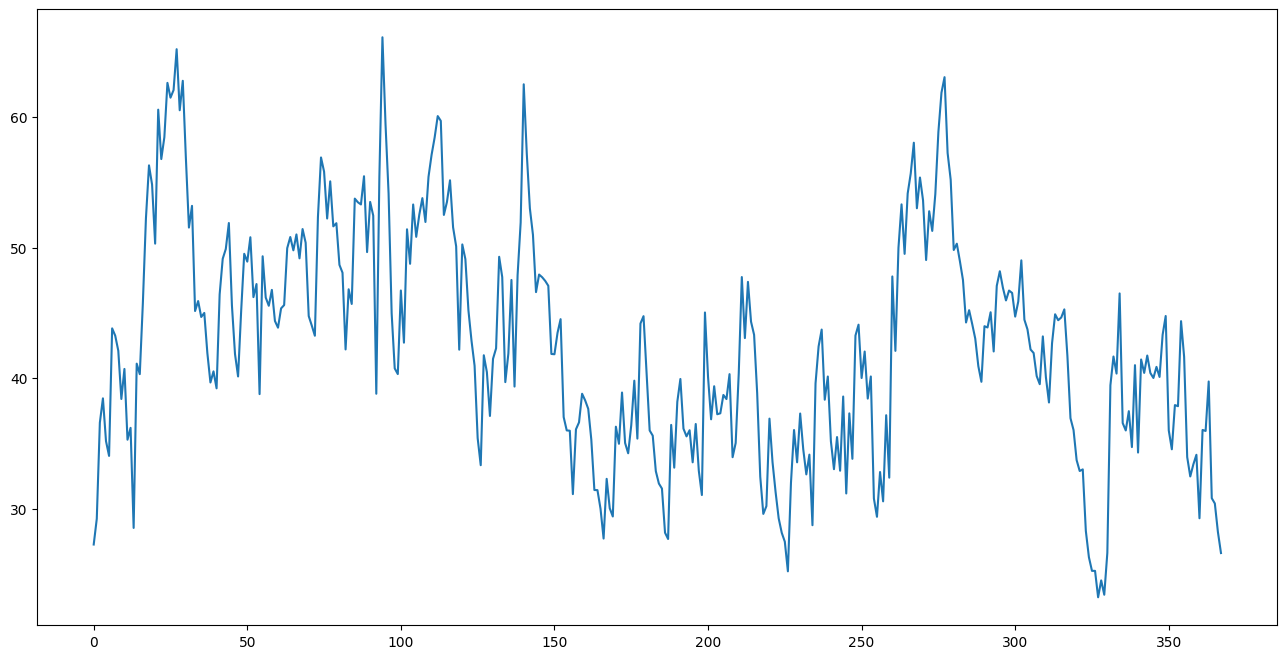

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.show()

In [ ]:
# ARIMA
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    forecasts.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f'Expected={yhat}, Observed={obs}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Expected=29.516630795320122, Observed=27.24487797641096
Expected=28.11399084877108, Observed=29.219845142066617
Expected=30.00067420084741, Observed=36.58372653061709
Expected=37.012742601570594, Observed=38.44572526767188
Expected=38.75335241816828, Observed=35.16749183710627
Expected=35.62181150936235, Observed=34.035723733325156
Expected=34.55781158998765, Observed=43.80927896661123
Expected=43.86791881449406, Observed=43.25164301927485
Expected=43.29132544189613, Observed=42.097510314348256
Expected=42.196095778872404, Observed=38.39772232255798
Expected=38.684560739001256, Observed=40.699343046107764
Expected=40.88671033612709, Observed=35.27755896315382
Expected=35.72525977416565, Observed=36.184016770055095
Expected=36.60339663151284, Observed=28.516565876372297
Expected=28.83689813232792, Observed=41.10418023117506
Expected=41.20779133240176, Observed=40.301361531947464
Expected=39.82302043275099, Observed=45.738870018543594
Expected=45.34056168627159, Observed=52.2260665590716

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=56.1748139719249, Observed=55.81789717404984
Expected=55.1986768289684, Observed=52.225826987197394
Expected=52.13961990956762, Observed=55.074588069938585
Expected=55.00664774464721, Observed=51.6254289031458
Expected=51.259761701560066, Observed=51.86706309057663
Expected=51.45272014206176, Observed=48.67492686349754
Expected=48.47014416103344, Observed=48.072685353995915
Expected=47.874987346743964, Observed=42.193866979426126
Expected=42.37076864533741, Observed=46.802945167243095


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=46.61820575877881, Observed=45.679807631958006
Expected=45.622397200411484, Observed=53.75096374920072
Expected=53.1388971991101, Observed=53.47182325464502
Expected=52.97555534382677, Observed=53.30332667011926
Expected=52.816351173314935, Observed=55.4656256338504
Expected=54.834037227387164, Observed=49.653498304939184
Expected=49.43597878794702, Observed=53.49514336284515
Expected=52.94354409602857, Observed=52.44868447492496


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=52.02216418979578, Observed=38.798216486501794
Expected=39.287609994619054, Observed=55.40292489690805
Expected=54.36985621273016, Observed=66.11362164165682
Expected=65.14879733591584, Observed=59.4731344431549
Expected=58.7475483474896, Observed=54.14527063072281
Expected=53.679353939196695, Observed=44.956206549227254
Expected=45.61836106561003, Observed=40.74024102196011
Expected=41.59600694943438, Observed=40.305990950769754
Expected=40.55157648701643, Observed=46.7105923701369
Expected=46.91613376586608, Observed=42.71214105558928
Expected=42.7933792024548, Observed=51.39952532012095
Expected=50.88462620809025, Observed=48.75577677016675
Expected=48.54687559242752, Observed=53.30081202352532
Expected=52.72490883474556, Observed=50.8222928703113
Expected=50.49580964809207, Observed=52.52075846002294
Expected=52.03272986972603, Observed=53.78732394953937
Expected=53.23549030441611, Observed=51.9606689899801
Expected=51.56227404616137, Observed=55.42327773160036
Expected=54

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=57.628497324436495, Observed=60.074166632189055
Expected=59.16978169680854, Observed=59.70725907862469
Expected=58.8563507144439, Observed=52.50206705126267
Expected=52.15818049671567, Observed=53.49244249864755


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=52.96751479880339, Observed=55.15483938693909
Expected=54.52698002267268, Observed=51.551792066154036
Expected=51.21212997194411, Observed=50.0956052140797
Expected=49.80550921836466, Observed=42.176464433192024


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=42.43698331928711, Observed=50.238988065142635
Expected=49.76816049945495, Observed=49.117056776479004
Expected=48.87987664402048, Observed=45.17601409268097
Expected=45.21805866269953, Observed=42.85706188886402
Expected=43.002382775541776, Observed=40.94477214273188
Expected=41.19301908874708, Observed=35.396786084591014
Expected=36.02588558577935, Observed=33.323374205660315
Expected=34.00980552457109, Observed=41.74790113934017
Expected=41.77532728335787, Observed=40.45734212556319


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=40.722083210022554, Observed=37.095793714575365
Expected=37.59119004258288, Observed=41.47374614954497


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=41.57826877095658, Observed=42.278414669824386
Expected=42.39986823733553, Observed=49.2931363753262
Expected=48.89992545968659, Observed=47.73681899102657


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=47.581271323295184, Observed=39.689798095300695
Expected=40.11485775960472, Observed=41.88535215841924
Expected=42.00639208876809, Observed=47.517456447782386
Expected=47.30226860760284, Observed=39.34873042247028


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=39.815571236379284, Observed=47.88429879156999
Expected=47.49589324095645, Observed=51.92053873442072
Expected=51.40559048614847, Observed=62.51038317234204


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=61.26636339905646, Observed=57.1575586475823


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=56.53217291435255, Observed=53.00442063206861


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=52.59078062629907, Observed=50.979029084644374


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=50.64229973765876, Observed=46.58593566078044
Expected=46.553002629151614, Observed=47.931853833740554


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=47.711401763262224, Observed=47.725998538068126
Expected=47.54738521808295, Observed=47.44265059841349


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=47.282590618922754, Observed=47.06975860435404
Expected=46.933728961389605, Observed=41.84790766645281
Expected=42.1145564910976, Observed=41.824880412172675
Expected=41.994547970142825, Observed=43.463831204697755


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=43.50436813302489, Observed=44.51273378976273
Expected=44.50183716778701, Observed=37.01118444297728
Expected=37.6112546661596, Observed=35.98877620222791
Expected=36.526790937937136, Observed=35.964901755657536
Expected=36.48213092873623, Observed=31.10632912303818


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=31.99816378699937, Observed=36.06951217947901


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=36.48226695366028, Observed=36.60816325041033
Expected=37.0745401306395, Observed=38.79730825430386
Expected=39.10153532907575, Observed=38.28742344740115
Expected=38.6744254433715, Observed=37.64199099747783
Expected=38.0687607792035, Observed=35.280831117660185


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=35.879976877048705, Observed=31.42118665145209
Expected=32.27388796367147, Observed=31.413700548836943


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=32.192467862026994, Observed=29.985573945560915
Expected=30.871233139084868, Observed=27.702282245507277
Expected=28.733351992961822, Observed=32.27831063783867
Expected=32.91496963070659, Observed=30.02321657439559
Expected=30.91962988204657, Observed=29.39289903148861
Expected=30.291123539904234, Observed=36.27399694491143
Expected=36.624829863067745, Observed=34.964110762161624
Expected=35.55289587342152, Observed=38.89176907856888
Expected=39.14185578953935, Observed=35.0266958797866
Expected=35.66720414844659, Observed=34.236526282306045
Expected=34.85684010614486, Observed=36.37998676648442


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=36.81121686976463, Observed=39.799733184964126
Expected=40.00355239379876, Observed=35.35999359497316
Expected=35.992214049912015, Observed=44.178746801985206
Expected=43.987025858078226, Observed=44.74342757163276
Expected=44.71122157659473, Observed=40.40137194273213
Expected=40.74106553391533, Observed=35.98364185899534
Expected=36.5826976390761, Observed=35.58674040280074
Expected=36.119966839395424, Observed=32.86924461664009
Expected=33.612001988677065, Observed=31.917203884558944


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=32.675479292360585, Observed=31.532378898350387
Expected=32.29900271512695, Observed=28.15175120059179
Expected=29.17703130699403, Observed=27.66901833922165
Expected=28.656122881601764, Observed=36.410832400564715
Expected=36.694359809150264, Observed=33.13451830756641
Expected=33.871880151132544, Observed=38.18328216271379
Expected=38.42831477811436, Observed=39.929885520894885
Expected=40.149935426033046, Observed=36.12622959698955
Expected=36.70180703032889, Observed=35.53154200696943
Expected=36.06543285511696, Observed=36.00316398263194


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=36.48331404255722, Observed=33.54399419518509


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=34.2367714109256, Observed=36.48129047615397
Expected=36.873023355808066, Observed=32.89342426029201
Expected=33.65282850195234, Observed=31.037915279870802
Expected=31.860891315098765, Observed=45.02641807223499
Expected=44.63125992706002, Observed=40.100632835648696
Expected=40.48699285852518, Observed=36.840047154458965
Expected=37.37094371978788, Observed=39.373273473114
Expected=39.59399198894935, Observed=37.22699813793101
Expected=37.70484271310574, Observed=37.29893581030674
Expected=37.7100865787215, Observed=38.70595301721489
Expected=38.995793036247896, Observed=38.39005469959907
Expected=38.746315296556936, Observed=40.301108833897935
Expected=40.480938256266825, Observed=33.93665905811618
Expected=34.73105567099812, Observed=35.02323227285983
Expected=35.538162078174516, Observed=40.35025620518164
Expected=40.42885016342531, Observed=47.740747454728194
Expected=47.332613310652334, Observed=43.06388925834924
Expected=43.261193397166075, Observed=47.37128411084035
E

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=32.1590066215765, Observed=37.29470304511153
Expected=37.48743103667096, Observed=33.81236031411511
Expected=34.53924974936363, Observed=43.25813537214131
Expected=42.95696728484895, Observed=44.09028685892308
Expected=44.04896139665504, Observed=40.00329453637625
Expected=40.384381968383416, Observed=42.03354873219448
Expected=42.073239523093434, Observed=38.42708039978472
Expected=38.888414812734545, Observed=40.12212450059549
Expected=40.28804096222176, Observed=30.771763384292896
Expected=31.91108190950186, Observed=29.369791141082985
Expected=30.292423195671574, Observed=32.79998610061696
Expected=33.342255769158676, Observed=30.55309213185609
Expected=31.4351018629838, Observed=37.1532286331756
Expected=37.31144563855272, Observed=32.36863377160833


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=33.246394363447365, Observed=47.786549600587286
Expected=46.89736285970447, Observed=42.08402057461262
Expected=42.44982339112122, Observed=49.98712208136341
Expected=49.235811361281435, Observed=53.310376801440505
Expected=52.580656157905715, Observed=49.51666899773891
Expected=49.34696472225603, Observed=54.14528622770989
Expected=53.30007094892432, Observed=55.68564866580768
Expected=54.896339800823554, Observed=58.03447720714399
Expected=57.06898877684517, Observed=53.0117050165015


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=52.69375667879413, Observed=55.3669242439819
Expected=54.55944871243902, Observed=53.621048406288004
Expected=53.11569681345075, Observed=49.04560448614758
Expected=48.95002541284902, Observed=52.78350671084149
Expected=52.064017641213795, Observed=51.27640570731557
Expected=50.902794841485985, Observed=54.105846089736424
Expected=53.35140904523394, Observed=58.86914182566245
Expected=57.73983431911764, Observed=61.86772604693072
Expected=60.65239913784174, Observed=63.05739725843093
Expected=61.86302849451217, Observed=57.24621677214837
Expected=56.72309892595447, Observed=55.19736220623644
Expected=54.61715574845487, Observed=49.81349711997208
Expected=49.70900065411139, Observed=50.29681141522956
Expected=49.89239682280512, Observed=48.95594269591834
Expected=48.71756642220816, Observed=47.512055413328135
Expected=47.3660660132419, Observed=44.26039627084043
Expected=44.39476258806451, Observed=45.20160293016284
Expected=45.085884915025645, Observed=44.14694628709162
Expect

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=43.888932489455705, Observed=45.04135612667386
Expected=44.9247226210688, Observed=42.03858874233797
Expected=42.29716349799988, Observed=47.065424257447994
Expected=46.64367126434248, Observed=48.18582360834846
Expected=47.87905454143245, Observed=46.92390204598312
Expected=46.805070146982935, Observed=45.94919858189475
Expected=45.87631999840507, Observed=46.70560549658848
Expected=46.50647221046275, Observed=46.52351595184967
Expected=46.37915382611758, Observed=44.71102700868199
Expected=44.75308267934675, Observed=45.865568877606286
Expected=45.69931460880205, Observed=49.020305228408816
Expected=48.56923991700864, Observed=44.471599538336086
Expected=44.657946926009295, Observed=43.729964536844285
Expected=43.782823061163256, Observed=42.19119167675983
Expected=42.37508842182646, Observed=41.921608922883955
Expected=42.06275704497989, Observed=40.15047224775823
Expected=40.46965836249401, Observed=39.529253340980986
Expected=39.832448718683764, Observed=43.19327470492032

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Expected=40.6528798041994, Observed=41.72819321820873
Expected=41.79000967721273, Observed=40.392528618767635
Expected=40.6665231403438, Observed=40.007308617806345
Expected=40.2582040777281, Observed=40.85769973971911
Expected=40.9957460536973, Observed=40.084089326052315
Expected=40.348854315783, Observed=43.31646575764107
Expected=43.1868259739499, Observed=44.75592034651751
Expected=44.62607598073871, Observed=35.990588316515286
Expected=36.900862385216534, Observed=34.542349069488466
Expected=35.17907872998046, Observed=37.93023515169518
Expected=38.12509450657947, Observed=37.84500633763924
Expected=38.213032600682254, Observed=44.36139779935465
Expected=44.008644169737785, Observed=41.62781356398821
Expected=41.8936361107399, Observed=33.94557303348185
Expected=34.920778202823406, Observed=32.46044304697212
Expected=33.22560282888577, Observed=33.38358470208
Expected=33.977541027626025, Observed=34.12204436855593
Expected=34.67901711948817, Observed=29.25697827340582
Expected=30

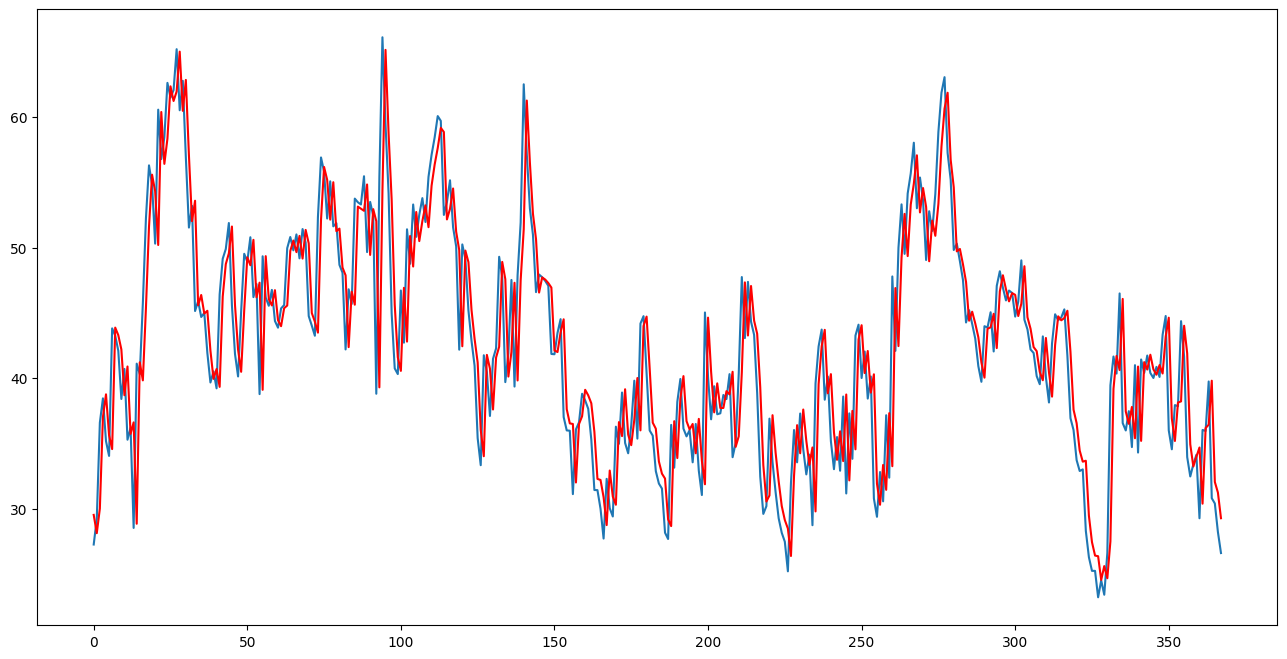

In [ ]:
# Test and forecast set
plt.figure(figsize=(16, 8))
plt.plot(test)
plt.plot(forecasts, color='red')
plt.show()

In [ ]:
# Ensuring that data is one-dimensional
test = test.ravel()
forecasts = np.array(forecasts).ravel()

In [ ]:
# Getting the high, low and close values ​​from the test set for the RSI
test_size_A = len(test)

rsi_test_A = base_A['RSI'].tail(test_size_A)
close_test_A = base_A['Close/Last'].tail(test_size_A)

In [ ]:
print(test.shape)
print(forecasts.shape)

(368,)
(368,)


In [ ]:
# Inverse RSI formula
def inverse_rsi_A(predictions_A, close_prices_A, rsi_values_A, period=14):
    inverted_values = []

    for rsi, pred, close in zip(rsi_values_A, predictions_A, close_prices_A):
        # Calculates real RS from RSI
        rs_real = (100 - rsi) / rsi

        # Reverse predicted RSI to get RS (relative strength) estimate
        rs_pred = (100 - pred) / pred

        # Calculates the price change based on the difference between actual and forecast RS considering that RS = average gains / average losses
        gain = (rs_pred - rs_real) * close / (1 + rs_real)
        inverted_price = close + gain

        inverted_values.append(inverted_price)

    return np.array(inverted_values)

In [ ]:
test_inverted = inverse_rsi_A(test, close_test_A, rsi_test_A)
forecasts_inverted = inverse_rsi_A(forecasts, close_test_A, rsi_test_A)

min_length_R = min(len(test_R), len(forecasts_inverted))
test_R = test_R[:min_length_R]
forecasts_inverted = forecasts_inverted[:min_length_R]

In [ ]:
# RMSE
rmse = sqrt(mean_squared_error(test_R, forecasts_inverted))
print(f'RMSE: {rmse}')

# R2 Score
r2 = r2_score(test_R, forecasts_inverted)
print(f'R2 Score: {r2}')

RMSE: 1.1073774335702007
R2 Score: 0.8916238970599423


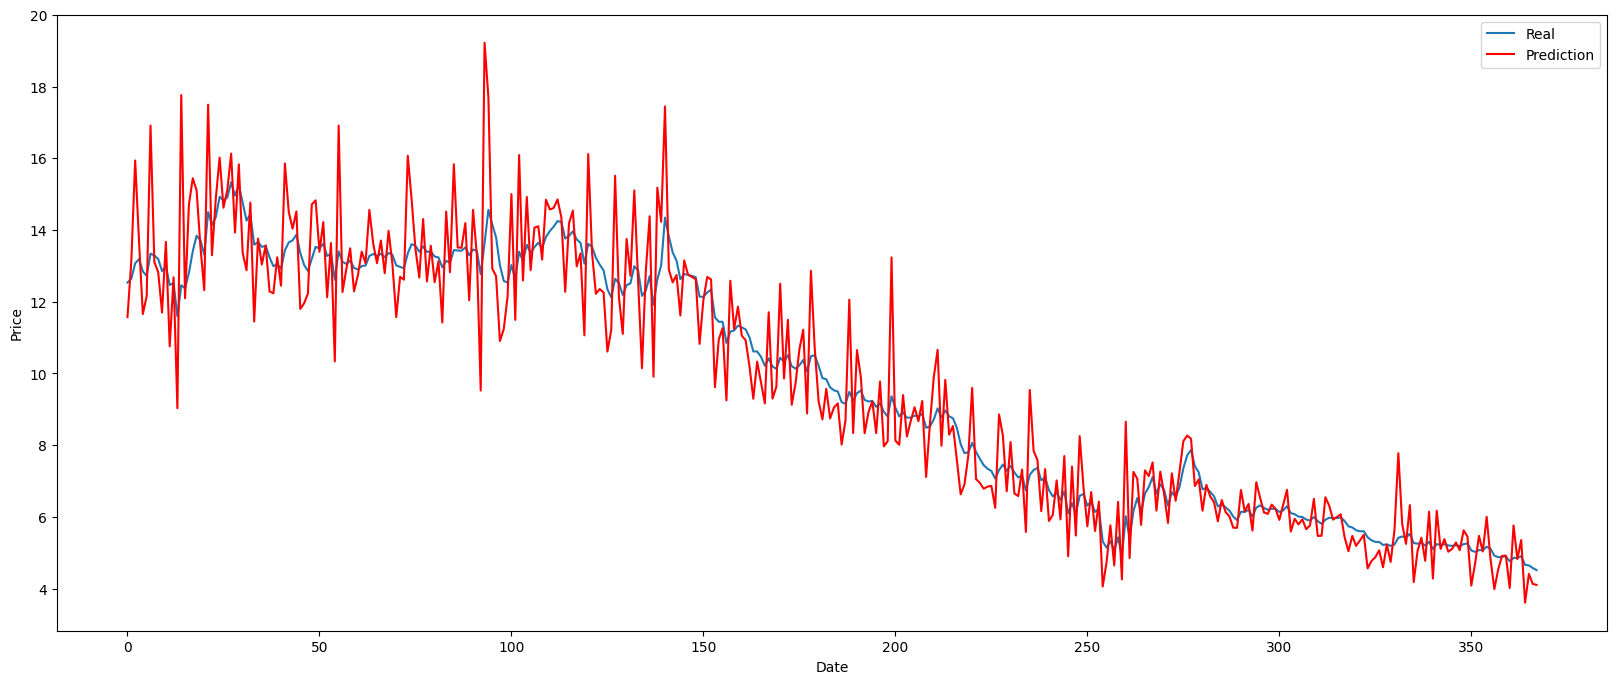

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(test_R)), test_R, label='Real')
plt.plot(range(len(forecasts_inverted)), forecasts_inverted, label='Prediction', color = 'red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()